In [2]:
import pandas as pd
import numpy as np
import pickle

In [4]:
file_names = {
    "train": "data/train_task_C1.xlsx",
    "test": "data/test_task_C1.xlsx",
    "val": "data/val_task_C1.xlsx",
    "mf_train": "data/mf_features_train_task_C1.xlsx",
    "mf_test": "data/mf_features_test_task_C1.xlsx",
    "mf_val": "data/mf_features_val_task_C1.xlsx",
}

In [7]:
#!pip install openpyxl

In [8]:
A_train = pd.read_excel(file_names["train"], index_col="id").sample(frac = 1, random_state=2022).reset_index()
A_val = pd.read_excel(file_names["val"])
A_test = pd.read_excel(file_names["test"])

<AxesSubplot: >

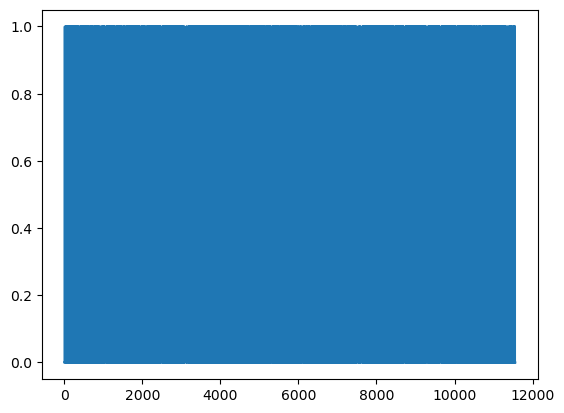

In [9]:
A_train["label"].plot()

In [10]:
%%time
mf_A_train = pd.read_excel(file_names["mf_train"])
mf_A_val = pd.read_excel(file_names["mf_val"])
mf_A_test = pd.read_excel(file_names["mf_test"])

CPU times: user 2min 19s, sys: 244 ms, total: 2min 19s
Wall time: 2min 19s


In [11]:
%%time
mf_A_train = mf_A_train.set_index("id").loc[A_train["id"]].reset_index()
mf_A_test = mf_A_test.set_index("id").loc[A_test["id"]].reset_index()
mf_A_val = mf_A_val.set_index("id").loc[A_val["id"]].reset_index()

CPU times: user 73.3 ms, sys: 23.9 ms, total: 97.2 ms
Wall time: 106 ms


In [12]:
rel_cols = [c for c in mf_A_train.columns if "id" != c and "linguistic" not in c]
len(rel_cols)

66

In [13]:
%%capture
!pip install transformers
!pip install datasets
!pip install torch

In [14]:
from transformers import BertTokenizer, BertModel
import torch

In [15]:
model_name = "dccuchile/bert-base-spanish-wwm-cased"
beto_model = BertModel.from_pretrained(model_name)
beto_tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=False)
e = beto_model.eval()

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
beto_tokenizer.all_special_tokens, beto_tokenizer.all_special_ids

(['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]'], [3, 5, 1, 4, 0])

In [17]:
from torch.utils.data import Dataset
class DatasetTaskC1(Dataset):
    def __init__(self, df, df_mf, maxlen):
        self.df = df
        self.df_mf = df_mf
        self.tokenizer = beto_tokenizer
        self.maxlen = maxlen

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        sentence1 = str(self.df.loc[index, 'Q'])
        sentence2 = str(self.df.loc[index, 'A'])
        
        sentence1 = " ".join(str(sentence1).replace("\n", " ").split())
        sentence2 = " ".join(str(sentence2).replace("\n", " ").split())

        label = self.df.loc[index, 'label']
        
        tokens1 = self.tokenizer.tokenize(sentence1) if len(sentence1)>0 else ["[UNK]"]
        tokens2 = self.tokenizer.tokenize(sentence2) if len(sentence2)>0 else ["[UNK]"]

        if len(tokens1) < self.maxlen:
            tokens1 = tokens1 + ['[PAD]' for _ in range(self.maxlen - len(tokens1))]
        else:
            tokens1 = tokens1[:self.maxlen]

        if len(tokens2) < self.maxlen:
            tokens2 = tokens2 + ['[PAD]' for _ in range(self.maxlen - len(tokens2))]
        else:
            tokens2 = tokens2[:self.maxlen]
          
        tokens = ["[CLS]"]+tokens1+["[SEP]"]+tokens2+["[SEP]"]
        tokens_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        tokens_ids_tensor = torch.tensor(tokens_ids)
        attn_mask = (tokens_ids_tensor != 1).long() # [PAD] => 1

        mf_tensor = torch.tensor(self.df_mf.loc[index, :].values)

        return mf_tensor, tokens_ids_tensor, attn_mask, label

In [35]:
from torch.utils.data import DataLoader

train_set = DatasetTaskC1(df = A_train, df_mf = mf_A_train[rel_cols].astype(float), maxlen = 60)
val_set = DatasetTaskC1(df = A_val, df_mf = mf_A_val[rel_cols].astype(float), maxlen = 60)

train_loader = DataLoader(train_set, batch_size = 32, num_workers = 2, shuffle=False)
val_loader = DataLoader(val_set, batch_size = 32, num_workers = 2, shuffle=False)

In [43]:
import torch.nn as nn
class C1Classifier(nn.Module):
    def __init__(self):
        super(C1Classifier, self).__init__()
        torch.manual_seed(2022)
        
        self.bert_layer = BertModel.from_pretrained(model_name).cuda()
        self.cls_layer = nn.Linear(66+768, 2).cuda()

    def forward(self, mfs, seq, attn_masks):

        cont_reps = self.bert_layer(seq, attention_mask=attn_masks)
        
        cls_rep = cont_reps.last_hidden_state[:, 0]
        mfs = mfs.to(cls_rep.dtype)
        cls_rep = torch.cat((mfs,cls_rep), 1)

        logits = self.cls_layer(cls_rep)

        return logits

In [53]:
import torch.optim as optim

net = C1Classifier()

weights = torch.tensor([1., 6.5])
criterion = nn.CrossEntropyLoss(weight=weights, reduction='mean').cuda()

opti = optim.Adam(net.parameters(), lr = 2e-5)

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [45]:
def get_accuracy_from_logits(logits, labels):
    probs = torch.sigmoid(logits)
    soft_probs = probs.argmax(1)
    acc = (soft_probs.squeeze() == labels).float().mean()
    return acc
    
def evaluate(net, criterion, dataloader):
    net.eval()
    mean_acc, mean_loss = 0, 0
    count = 0
    with torch.no_grad():
        for mfs, seq, attn_masks, labels in dataloader:
            mfs, seq, attn_masks, labels = mfs.cuda(), seq.cuda(), attn_masks.cuda(), labels.cuda()
            logits = net(mfs, seq, attn_masks)
            mean_loss += criterion(logits, labels).item()
            mean_acc += get_accuracy_from_logits(logits, labels)
            count += 1

    return mean_acc / count, mean_loss / count

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

def evaluate_precision_recall_fscore_support(net, dataloader):
    net.eval()
    preds = []
    tests = []
    with torch.no_grad():
        for mfs, seq, attn_masks, labels in dataloader:
            mfs, seq, attn_masks, labels = mfs.cuda(), seq.cuda(), attn_masks.cuda(), labels.cuda()
            logits = net(mfs, seq, attn_masks)
            probs = torch.sigmoid(logits)
            soft_probs = probs.argmax(1)
            preds += soft_probs.squeeze().tolist()
            tests += labels.tolist()
    return tests, preds

In [46]:
def train(net, criterion, opti, train_loader, val_loader, epochs):
    for ep in range(epochs):
        for it, (mfs, seq, attn_masks, labels) in enumerate(train_loader):
            opti.zero_grad()  

            mfs, seq, attn_masks, labels = mfs.cuda(), seq.cuda(), attn_masks.cuda(), labels.cuda()

            logits = net(mfs, seq, attn_masks)

            loss = criterion(logits, labels)

            loss.backward()

            opti.step()

            if (it + 1) % 100 == 0:
                acc = get_accuracy_from_logits(logits, labels)
                # tests, preds = evaluate_precision_recall_fscore_support(net, train_loader)
                # print(classification_report(tests, preds))
                print("Iteration {} of epoch {} complete. Loss : {} Train Accuracy : {}".format(it+1, ep+1, loss.item(), acc))
        val_acc, val_loss = evaluate(net, criterion, val_loader)
        tests, preds = evaluate_precision_recall_fscore_support(net, val_loader)
        print(classification_report(tests, preds))
        print("Epoch {} complete! Validation Accuracy : {}, Validation Loss : {}".format(ep+1, val_acc, val_loss))

In [54]:
epochs = 5
train(net, criterion, opti, train_loader, val_loader, epochs)

Iteration 100 of epoch 1 complete. Loss : 0.25465142726898193 Train Accuracy : 0.90625
Iteration 200 of epoch 1 complete. Loss : 0.26307180523872375 Train Accuracy : 0.96875
Iteration 300 of epoch 1 complete. Loss : 0.6701672077178955 Train Accuracy : 0.9375
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2510
           1       0.80      0.82      0.81       388

    accuracy                           0.95      2898
   macro avg       0.89      0.89      0.89      2898
weighted avg       0.95      0.95      0.95      2898

Epoch 1 complete! Validation Accuracy : 0.9489087462425232, Validation Loss : 0.2551502956097925
Iteration 100 of epoch 2 complete. Loss : 0.10069958120584488 Train Accuracy : 0.9375
Iteration 200 of epoch 2 complete. Loss : 0.12246681749820709 Train Accuracy : 0.96875
Iteration 300 of epoch 2 complete. Loss : 0.011322111822664738 Train Accuracy : 1.0
              precision    recall  f1-score   support

     

In [56]:
from huggingface_hub import notebook_login

In [6]:
notebook_login()

In [61]:
!git config --global credential.helper store

In [1]:
repo_name = "beto_hf_ft_task_C1"
net.bert_layer.push_to_hub(repo_name)

NameError: name 'net' is not defined

In [2]:
val_set.tokenizer.push_to_hub(repo_name)

NameError: name 'val_set' is not defined

In [65]:
torch.save(net.cls_layer, "cls_layer.torch")

In [66]:
from huggingface_hub import hf_hub_url, cached_download

In [4]:
repo_name = "beto_hf_ft_task_C1"
config_file_url = hf_hub_url("X/"+repo_name, filename="cls_layer.torch")
value = cached_download(config_file_url)
cls_layer = torch.load(value)

NameError: name 'hf_hub_url' is not defined

In [5]:
beto_model = BertModel.from_pretrained("X/"+repo_name).cuda()
beto_tokenizer = BertTokenizer.from_pretrained("X/"+repo_name, do_lower_case=False)
e = beto_model.eval()

NameError: name 'BertModel' is not defined

In [69]:
def preproccesing(Q, A, maxlen=60):
        sentence1 = str(Q)
        sentence2 = str(A)
        
        sentence1 = " ".join(str(sentence1).replace("\n", " ").split())
        sentence2 = " ".join(str(sentence2).replace("\n", " ").split())
        
        tokens1 = beto_tokenizer.tokenize(sentence1) if len(sentence1)>0 else ["[UNK]"]
        tokens2 = beto_tokenizer.tokenize(sentence2) if len(sentence2)>0 else ["[UNK]"]

        if len(tokens1) < maxlen:
            tokens1 = tokens1 + ['[PAD]' for _ in range(maxlen - len(tokens1))]
        else:
            tokens1 = tokens1[:maxlen]

        if len(tokens2) < maxlen:
            tokens2 = tokens2 + ['[PAD]' for _ in range(maxlen - len(tokens2))]
        else:
            tokens2 = tokens2[:maxlen]
          
        tokens = ["[CLS]"]+tokens1+["[SEP]"]+tokens2+["[SEP]"]
        # tokens = [x for x in tokens if x!="[PAD]"]
        tokens_ids = beto_tokenizer.convert_tokens_to_ids(tokens)
        tokens_ids_tensor = torch.tensor(tokens_ids)
        attn_mask = (tokens_ids_tensor != 1).long() # [PAD] => 1

        return tokens_ids_tensor.cuda(), attn_mask.cuda()

In [100]:
def C1Classifier(mfs, Q, A):
    tokens_ids_tensor, attn_mask = preproccesing(Q, A)
    cont_reps = beto_model(tokens_ids_tensor.unsqueeze(0), attention_mask = attn_mask.unsqueeze(0))
    cls_rep = cont_reps.last_hidden_state[:, 0]
    mfs = torch.tensor(mfs).cuda()
    mfs = mfs.to(cls_rep.dtype).unsqueeze(0)
    cls_rep = torch.cat((mfs,cls_rep), 1)
    logits = cls_layer(cls_rep)
    probs = torch.sigmoid(logits)
    return probs.detach().cpu().numpy()[0]

In [101]:
i = 0
mfs = mf_A_train.iloc[i][rel_cols]
Q = A_train.iloc[i]["Q"], 
A = A_train.iloc[i]["A"]
print(Q, A)
C1Classifier(mfs, Q, A)

('Luis compró 10 caramelos, de los cuales 4 tenían menta, los demás no. ¿Cuántos caramelos no tenían menta? Representa esta ecuación.',) tiene 30 en total


array([0.98354834, 0.02162533], dtype=float32)

In [102]:
from sklearn.metrics import classification_report

In [103]:
%%time
y_pred = [ int(
    C1Classifier(
        mfs=mf_A_train.iloc[i][rel_cols], 
        Q=A_train.iloc[i]["Q"], 
        A=A_train.iloc[i]["A"]
        )[0]<0.5) 
    for i in range(A_train.shape[0])
]
report = classification_report(A_train["label"], y_pred, output_dict=True)
train_report = pd.DataFrame(report)
train_report

CPU times: user 1min 50s, sys: 30.2 ms, total: 1min 50s
Wall time: 1min 50s


,0,1,accuracy,macro avg,weighted avg
precision,0.998901,0.985816,0.997145,0.992358,0.997158
recall,0.997804,0.992857,0.997145,0.995331,0.997145
f1-score,0.998352,0.989324,0.997145,0.993838,0.997149
support,10019.000000,1540.000000,0.997145,11559.000000,11559.000000


In [104]:
pickle.dump(y_pred, open("data/y_pred_train_beto_hf_ft_task_C1.pickle", "wb"))

In [105]:
%%time
y_pred = [ int(
    C1Classifier(
        mf_A_val.iloc[i][rel_cols], 
        A_val.iloc[i]["Q"], 
        A_val.iloc[i]["A"]
        )[0]<0.5) 
    for i in range(A_val.shape[0])]
report = classification_report(A_val["label"], y_pred, output_dict=True)
val_report = pd.DataFrame(report)
val_report

CPU times: user 27.1 s, sys: 8.18 ms, total: 27.1 s
Wall time: 27.1 s


,0,1,accuracy,macro avg,weighted avg
precision,0.970901,0.884507,0.960317,0.927704,0.959334
recall,0.983665,0.809278,0.960317,0.896472,0.960317
f1-score,0.977241,0.845222,0.960317,0.911232,0.959566
support,2510.000000,388.000000,0.960317,2898.000000,2898.000000


In [106]:
pickle.dump(y_pred, open("data/y_pred_val_beto_hf_ft_task_C1.pickle", "wb"))

In [107]:
%%time
y_pred = [ int(
    C1Classifier(
        mf_A_test.iloc[i][rel_cols], 
        A_test.iloc[i]["Q"], 
        A_test.iloc[i]["A"]
        )[0]<0.5) 
    for i in range(A_test.shape[0])]
report = classification_report(A_test["label"], y_pred, output_dict=True)
test_report = pd.DataFrame(report)
test_report

CPU times: user 6.59 s, sys: 1.01 ms, total: 6.59 s
Wall time: 6.59 s


,0,1,accuracy,macro avg,weighted avg
precision,0.932384,0.852174,0.918759,0.892279,0.916271
recall,0.968577,0.720588,0.918759,0.844582,0.918759
f1-score,0.950136,0.780876,0.918759,0.865506,0.916134
support,541.000000,136.000000,0.918759,677.000000,677.000000


In [108]:
pickle.dump(y_pred, open("data/y_pred_test_beto_hf_ft_task_C1.pickle", "wb"))

In [29]:
import pandas as pd 
import pickle
from sklearn.metrics import classification_report
import numpy as np

file_names = {
    "train": "data/train_task_C1.xlsx",
    "test": "data/test_task_C1.xlsx",
    "val": "data/val_task_C1.xlsx",
    "mf_train": "data/mf_features_train_task_C1.xlsx",
    "mf_test": "data/mf_features_test_task_C1.xlsx",
    "mf_val": "data/mf_features_val_task_C1.xlsx",
}
A_test = pd.read_excel(file_names["test"])
test_label_Q = pd.read_excel("data/gpt_label_v7_comp.xlsx")
A_test["label_Q"] = A_test.apply(lambda x: test_label_Q[test_label_Q["id"] == x["id"]].iloc[0]["tipo_preg"], axis=1)
y_pred = pickle.load(open("data/y_pred_test_beto_hf_ft_task_C1.pickle", "rb"))
sub_index_test = A_test["label_Q"] == 3
print(classification_report(A_test.loc[A_test[sub_index_test].index]["label"], np.array(y_pred)[sub_index_test.values], digits=4))

              precision    recall  f1-score   support

           0     0.9739    0.9962    0.9849       262
           1     0.9714    0.8293    0.8947        41

    accuracy                         0.9736       303
   macro avg     0.9727    0.9127    0.9398       303
weighted avg     0.9735    0.9736    0.9727       303

